In [1]:
import numpy as np
import pandas as pd

import torch

from gaussian_ring_grid_generator import GaussianRingSpaceTimeGrid
import encoder
import importlib
importlib.reload(encoder)

<module 'encoder' from '/home/ns4486/repos/numerical-relativity-interpolation/dev/encoder_sr/encoder.py'>

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
spaceTimeContext = GaussianRingSpaceTimeGrid(
    n_space_grid = 32,
    n_time_grid = 5,
    space_min_x = -5,
    space_max_x = 5,
    time_min_t = 0.5,
    time_max_t = 2.5
)

/home/ns4486/repos/numerical-relativity-interpolation/dev/encoder_sr/gaussian_ring_grid_generator.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [torch.tensor(GaussianRing(self.space_grid.cpu(), i, i/2)).unsqueeze(0) for i in self.time_axis]


In [4]:
spaceTimeContext.values.cpu().numpy().shape

(5, 1, 32, 32, 32)

In [5]:
spaceTimeContext.time_axis

tensor([0.5000, 1.0000, 1.5000, 2.0000, 2.5000], device='cuda:0')

In [6]:
train_grid = GaussianRingSpaceTimeGrid(
    n_space_grid = 48,
    n_time_grid = 4,
    space_min_x = -5,
    space_max_x = 5,
    time_min_t = 0.75,
    time_max_t = 2.25
)

In [7]:
train_grid.time_axis

tensor([0.7500, 1.2500, 1.7500, 2.2500], device='cuda:0')

In [8]:
train_grid.values.shape

torch.Size([4, 1, 48, 48, 48])

In [9]:
def get_decimal_index(axis_values, value):
    closest_above = axis_values[axis_values >= value].min()
    closest_below = axis_values[axis_values <= value].max()
    index_below = np.where(axis_values == closest_below)[0][0]
    
    if closest_above == closest_below:
        return index_below
    
    return index_below + ((value - closest_below)/(closest_above - closest_below))

In [10]:
get_decimal_index(spaceTimeContext.time_axis.cpu().numpy(), 2.2500)

3.5

In [11]:
ts = []
xs = []
ys = []
zs = []

vals = []

for i in range(train_grid.values.shape[0]):
    t = get_decimal_index(spaceTimeContext.time_axis.cpu().numpy(), train_grid.time_axis[i].item())
    
    for j in range(train_grid.values.shape[2]):
        x = get_decimal_index(spaceTimeContext.space_axis.cpu().numpy(), train_grid.space_axis[j].item())
        
        for k in range(train_grid.values.shape[3]):
            y = get_decimal_index(spaceTimeContext.space_axis.cpu().numpy(), train_grid.space_axis[k].item())
            
            for l in range(train_grid.values.shape[4]):
                z = get_decimal_index(spaceTimeContext.space_axis.cpu().numpy(), train_grid.space_axis[l].item())
                
                ts.append(t)
                xs.append(x)
                ys.append(y)
                zs.append(z)
                vals.append(train_grid.values[i, 0, j, k, l].item())

In [12]:
# import matplotlib.pyplot as plt

# plt.hist(vals, bins=100)

In [13]:
inps = np.array([ts, xs, ys, zs]).T
outs = np.array(vals)
inps.shape, outs.shape

((442368, 4), (442368,))

In [14]:
input_tensor = torch.Tensor(inps).unsqueeze(1)
output_tensor = torch.Tensor(outs).unsqueeze(1)
input_tensor.shape, output_tensor.shape

(torch.Size([442368, 1, 4]), torch.Size([442368, 1]))

In [15]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(input_tensor,output_tensor) # create your datset
train_dataloader = DataLoader(train_dataset, batch_size=2048, shuffle=True) # create your dataloader

In [16]:
import torch.nn as nn

model = encoder.SR(1, 16, 5)

In [17]:
import torch.optim as optim

criterion = nn.SmoothL1Loss()
recon_criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [18]:
import tqdm
import pickle

torch.manual_seed(123)

model.to(device)
model.train()

losses = []

for epoch in range(1000):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in tqdm.tqdm(enumerate(train_dataloader, 0)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        point_outputs, reconstruction = model(spaceTimeContext.values, inputs)
#         print(inputs)
#         print(labels)
        
        point_loss = criterion(point_outputs, labels)
        recon_loss = recon_criterion(reconstruction, spaceTimeContext.values)
        
        loss = point_loss + recon_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    
    if epoch % 30 == 0:
        torch.save(model.state_dict(), f'/scratch/ns4486/capstone/checkpoints/encoder_sr/conf3_epoch={epoch}.pt')
        with open(f'/scratch/ns4486/capstone/checkpoints/encoder_sr/conf3_loss_list_epoch={epoch}.pkl', 'wb') as f:
            pickle.dump(losses, f)
    
    print(f"epoch {epoch} loss = {running_loss/(i+1)}")
    losses.append(running_loss/(i+1))

print('Finished Training')

216it [00:18, 11.95it/s]
1it [00:00,  9.25it/s]

epoch 0 loss = 0.012368737575511827


216it [00:17, 12.58it/s]
1it [00:00,  5.91it/s]

epoch 1 loss = 0.0021270530226131625


216it [00:17, 12.49it/s]
1it [00:00,  9.40it/s]

epoch 2 loss = 0.0015573399833994227


216it [00:17, 12.52it/s]
1it [00:00,  9.70it/s]

epoch 3 loss = 0.0012149495418675037


216it [00:17, 12.51it/s]
1it [00:00,  9.31it/s]

epoch 4 loss = 0.00107696135630788


216it [00:17, 12.53it/s]
1it [00:00,  9.76it/s]

epoch 5 loss = 0.0009961509877703739


216it [00:17, 12.50it/s]
1it [00:00,  9.43it/s]

epoch 6 loss = 0.0009337125895264628


216it [00:17, 12.54it/s]
1it [00:00,  9.83it/s]

epoch 7 loss = 0.000875196702340704


216it [00:17, 12.54it/s]
1it [00:00,  9.53it/s]

epoch 8 loss = 0.0008329543721898786


216it [00:17, 12.57it/s]
1it [00:00,  9.42it/s]

epoch 9 loss = 0.0007820834870034121


216it [00:17, 12.51it/s]
1it [00:00,  9.53it/s]

epoch 10 loss = 0.0007375343701386117


216it [00:17, 12.50it/s]
1it [00:00,  9.55it/s]

epoch 11 loss = 0.0006689655217794805


216it [00:17, 12.54it/s]
1it [00:00,  9.65it/s]

epoch 12 loss = 0.0006196417187446194


216it [00:17, 12.54it/s]
1it [00:00,  9.51it/s]

epoch 13 loss = 0.0005851823338566141


216it [00:17, 12.51it/s]
1it [00:00,  9.44it/s]

epoch 14 loss = 0.0005259450246942126


216it [00:17, 12.55it/s]
1it [00:00,  9.68it/s]

epoch 15 loss = 0.0004840126615885378


216it [00:17, 12.59it/s]
1it [00:00,  5.92it/s]

epoch 16 loss = 0.00044536543295921376


216it [00:17, 12.54it/s]
1it [00:00,  9.65it/s]

epoch 17 loss = 0.0004169971512224206


216it [00:17, 12.52it/s]
1it [00:00,  9.62it/s]

epoch 18 loss = 0.00037600371359547825


216it [00:17, 12.54it/s]
1it [00:00,  9.67it/s]

epoch 19 loss = 0.0003665090685832116


216it [00:17, 12.55it/s]
1it [00:00,  9.79it/s]

epoch 20 loss = 0.00031350262573444826


216it [00:17, 12.52it/s]
1it [00:00,  9.73it/s]

epoch 21 loss = 0.0002989074950568869


216it [00:17, 12.54it/s]
1it [00:00,  9.72it/s]

epoch 22 loss = 0.0002821534721146303


216it [00:17, 12.52it/s]
1it [00:00,  9.77it/s]

epoch 23 loss = 0.0002547236003414986


216it [00:17, 12.59it/s]
1it [00:00,  9.82it/s]

epoch 24 loss = 0.0002495133060249457


216it [00:17, 12.52it/s]
1it [00:00,  9.75it/s]

epoch 25 loss = 0.00022195833271662532


216it [00:17, 12.54it/s]
1it [00:00,  9.79it/s]

epoch 26 loss = 0.00020880447856244346


216it [00:17, 12.52it/s]
1it [00:00,  9.73it/s]

epoch 27 loss = 0.00019719173603031473


216it [00:17, 12.54it/s]
1it [00:00,  9.88it/s]

epoch 28 loss = 0.00018001638003355496


216it [00:17, 12.53it/s]
1it [00:00,  9.78it/s]

epoch 29 loss = 0.00017743540832237126


216it [00:17, 12.50it/s]
1it [00:00,  9.86it/s]

epoch 30 loss = 0.00015067064113180904


216it [00:17, 12.56it/s]
1it [00:00,  5.94it/s]

epoch 31 loss = 0.00015814342434707754


216it [00:17, 12.54it/s]
2it [00:00, 11.70it/s]

epoch 32 loss = 0.00014755191356622768


216it [00:17, 12.53it/s]
1it [00:00,  9.86it/s]

epoch 33 loss = 0.00012891352391172268


216it [00:17, 12.52it/s]
2it [00:00, 11.70it/s]

epoch 34 loss = 0.00011785456212641697


216it [00:17, 12.51it/s]
1it [00:00,  9.79it/s]

epoch 35 loss = 0.00011871004717586739


216it [00:17, 12.53it/s]
2it [00:00, 11.72it/s]

epoch 36 loss = 0.00011609326133178979


216it [00:17, 12.53it/s]
1it [00:00,  9.92it/s]

epoch 37 loss = 0.00011212046021885019


216it [00:17, 12.58it/s]
1it [00:00,  6.33it/s]

epoch 38 loss = 0.0001017796689161009


216it [00:17, 12.50it/s]
1it [00:00,  9.91it/s]

epoch 39 loss = 0.00010078783375151775


216it [00:17, 12.48it/s]
2it [00:00, 11.45it/s]

epoch 40 loss = 8.958252970438075e-05


216it [00:17, 12.53it/s]
1it [00:00,  9.99it/s]

epoch 41 loss = 9.724831667241503e-05


216it [00:17, 12.57it/s]
2it [00:00, 11.48it/s]

epoch 42 loss = 9.360650229037101e-05


216it [00:17, 12.52it/s]
1it [00:00,  9.91it/s]

epoch 43 loss = 8.758914117168859e-05


216it [00:17, 12.50it/s]
2it [00:00, 11.51it/s]

epoch 44 loss = 8.525832826880678e-05


216it [00:17, 12.52it/s]
1it [00:00,  9.99it/s]

epoch 45 loss = 8.264144660777809e-05


216it [00:17, 12.56it/s]
1it [00:00,  9.93it/s]

epoch 46 loss = 7.55945489648487e-05


216it [00:17, 12.54it/s]
2it [00:00, 11.55it/s]

epoch 47 loss = 7.50587279004254e-05


216it [00:17, 12.45it/s]
1it [00:00,  9.87it/s]

epoch 48 loss = 7.37708830406013e-05


216it [00:17, 12.51it/s]
2it [00:00, 11.54it/s]

epoch 49 loss = 7.367130462996472e-05


216it [00:17, 12.52it/s]
1it [00:00, 10.00it/s]

epoch 50 loss = 6.659139155460623e-05


216it [00:17, 12.51it/s]
1it [00:00,  9.97it/s]

epoch 51 loss = 6.487568306410039e-05


216it [00:17, 12.49it/s]
1it [00:00,  9.95it/s]

epoch 52 loss = 6.587243321384314e-05


216it [00:17, 12.56it/s]
1it [00:00,  6.08it/s]

epoch 53 loss = 6.413642924801227e-05


216it [00:17, 12.51it/s]
1it [00:00,  9.91it/s]

epoch 54 loss = 5.726905171151749e-05


216it [00:17, 12.50it/s]
2it [00:00, 11.64it/s]

epoch 55 loss = 5.749636349921477e-05


216it [00:17, 12.49it/s]
1it [00:00,  9.96it/s]

epoch 56 loss = 6.0093953093369406e-05


216it [00:17, 12.48it/s]
2it [00:00, 11.67it/s]

epoch 57 loss = 5.387980971776145e-05


216it [00:17, 12.51it/s]
2it [00:00, 11.57it/s]

epoch 58 loss = 5.6002442155052755e-05


216it [00:17, 12.51it/s]
2it [00:00, 11.63it/s]

epoch 59 loss = 4.923551215664769e-05


216it [00:17, 12.49it/s]
1it [00:00,  9.98it/s]

epoch 60 loss = 5.5564796765692234e-05


216it [00:17, 12.54it/s]
0it [00:00, ?it/s]

epoch 61 loss = 5.306261770480584e-05


216it [00:17, 12.50it/s]
2it [00:00, 11.59it/s]

epoch 62 loss = 4.752023799617881e-05


216it [00:17, 12.51it/s]
2it [00:00, 11.70it/s]

epoch 63 loss = 4.98774284854638e-05


216it [00:17, 12.51it/s]
2it [00:00, 11.57it/s]

epoch 64 loss = 4.7777130627461396e-05


216it [00:17, 12.48it/s]
2it [00:00, 11.67it/s]

epoch 65 loss = 4.2969738274223346e-05


216it [00:17, 12.51it/s]
2it [00:00, 11.60it/s]

epoch 66 loss = 4.410812944452455e-05


216it [00:17, 12.46it/s]
2it [00:00, 11.63it/s]

epoch 67 loss = 3.8953783313512826e-05


216it [00:17, 12.55it/s]
1it [00:00,  6.07it/s]

epoch 68 loss = 4.318696499096943e-05


216it [00:17, 12.48it/s]
2it [00:00, 11.82it/s]

epoch 69 loss = 4.050959655109586e-05


216it [00:17, 12.49it/s]
2it [00:00, 11.63it/s]

epoch 70 loss = 4.1058617912144485e-05


216it [00:17, 12.49it/s]
2it [00:00, 11.92it/s]

epoch 71 loss = 4.216301839379513e-05


216it [00:17, 12.51it/s]
2it [00:00, 11.60it/s]

epoch 72 loss = 3.690599501843045e-05


216it [00:17, 12.47it/s]
2it [00:00, 11.84it/s]

epoch 73 loss = 4.0590002687100355e-05


216it [00:17, 12.50it/s]
2it [00:00, 11.60it/s]

epoch 74 loss = 3.6919776637963274e-05


216it [00:17, 12.55it/s]
1it [00:00,  6.37it/s]

epoch 75 loss = 3.5066141570631e-05


216it [00:17, 12.48it/s]
0it [00:00, ?it/s]

epoch 76 loss = 3.538666551658362e-05


216it [00:17, 12.51it/s]
2it [00:00, 11.56it/s]

epoch 77 loss = 3.266552982529026e-05


216it [00:17, 12.49it/s]
2it [00:00, 11.59it/s]

epoch 78 loss = 3.232071421061172e-05


216it [00:17, 12.52it/s]
2it [00:00, 11.56it/s]

epoch 79 loss = 3.9246164769119115e-05


216it [00:17, 12.51it/s]
2it [00:00, 11.68it/s]

epoch 80 loss = 3.165683958909708e-05


216it [00:17, 12.50it/s]
2it [00:00, 11.54it/s]

epoch 81 loss = 3.7792355240324265e-05


216it [00:17, 12.49it/s]
2it [00:00, 11.67it/s]

epoch 82 loss = 3.0719888888631465e-05


216it [00:17, 12.56it/s]
0it [00:00, ?it/s]

epoch 83 loss = 3.243851710976742e-05


216it [00:17, 12.51it/s]
2it [00:00, 11.62it/s]

epoch 84 loss = 2.9456287393259117e-05


216it [00:17, 12.50it/s]
2it [00:00, 11.63it/s]

epoch 85 loss = 2.7146779197445774e-05


216it [00:17, 12.43it/s]
2it [00:00, 11.58it/s]

epoch 86 loss = 3.666094085440784e-05


216it [00:17, 12.51it/s]
2it [00:00, 11.57it/s]

epoch 87 loss = 2.8099632711726168e-05


216it [00:17, 12.51it/s]
2it [00:00, 11.66it/s]

epoch 88 loss = 2.9873942855408165e-05


216it [00:17, 12.50it/s]
2it [00:00, 11.62it/s]

epoch 89 loss = 3.0042444121944653e-05


216it [00:17, 12.53it/s]
1it [00:00,  6.08it/s]

epoch 90 loss = 2.7815721952922307e-05


216it [00:17, 12.49it/s]
0it [00:00, ?it/s]

epoch 91 loss = 2.9756908285586785e-05


216it [00:17, 12.51it/s]
2it [00:00, 11.64it/s]

epoch 92 loss = 2.6296004008414725e-05


216it [00:17, 12.50it/s]
2it [00:00, 11.54it/s]

epoch 93 loss = 3.044982638037389e-05


216it [00:17, 12.49it/s]
2it [00:00, 11.63it/s]

epoch 94 loss = 2.5350244119113927e-05


216it [00:17, 12.44it/s]
2it [00:00, 11.62it/s]

epoch 95 loss = 2.7417518140282482e-05


216it [00:17, 12.51it/s]
2it [00:00, 11.63it/s]

epoch 96 loss = 2.7869092272575706e-05


216it [00:17, 12.50it/s]
2it [00:00, 11.62it/s]

epoch 97 loss = 3.073718771575942e-05


216it [00:17, 12.54it/s]
0it [00:00, ?it/s]

epoch 98 loss = 2.421871344419439e-05


216it [00:17, 12.48it/s]
2it [00:00, 11.62it/s]

epoch 99 loss = 2.4610190490858696e-05


216it [00:17, 12.49it/s]
2it [00:00, 11.68it/s]

epoch 100 loss = 2.346448340412516e-05


216it [00:17, 12.49it/s]
2it [00:00, 11.58it/s]

epoch 101 loss = 2.5501822148254615e-05


216it [00:17, 12.50it/s]
2it [00:00, 11.64it/s]

epoch 102 loss = 2.3023972079061895e-05


216it [00:17, 12.48it/s]
2it [00:00, 11.59it/s]

epoch 103 loss = 2.631188328063285e-05


216it [00:17, 12.44it/s]
2it [00:00, 11.72it/s]

epoch 104 loss = 2.5632903695319936e-05


216it [00:17, 12.54it/s]
1it [00:00,  6.08it/s]

epoch 105 loss = 2.07728467271577e-05


216it [00:17, 12.48it/s]
2it [00:00, 11.91it/s]

epoch 106 loss = 2.213114920255908e-05


216it [00:17, 12.48it/s]
2it [00:00, 11.52it/s]

epoch 107 loss = 2.086033299940903e-05


216it [00:17, 12.50it/s]
2it [00:00, 11.84it/s]

epoch 108 loss = 2.6067619766460364e-05


216it [00:17, 12.50it/s]
2it [00:00, 11.61it/s]

epoch 109 loss = 2.201855844490368e-05


216it [00:17, 12.50it/s]
2it [00:00, 11.81it/s]

epoch 110 loss = 2.3020023890980895e-05


216it [00:17, 12.51it/s]
2it [00:00, 11.54it/s]

epoch 111 loss = 2.3826290158821292e-05


216it [00:17, 12.54it/s]
1it [00:00,  6.42it/s]

epoch 112 loss = 2.1291939146050464e-05


216it [00:17, 12.45it/s]
0it [00:00, ?it/s]

epoch 113 loss = 2.29936777663574e-05


216it [00:17, 12.50it/s]
2it [00:00, 11.56it/s]

epoch 114 loss = 2.5060848090392768e-05


216it [00:17, 12.47it/s]
1it [00:00,  9.96it/s]

epoch 115 loss = 1.9811205112950523e-05


216it [00:17, 12.47it/s]
2it [00:00, 11.55it/s]

epoch 116 loss = 2.4467322204044547e-05


216it [00:17, 12.50it/s]
2it [00:00, 11.67it/s]

epoch 117 loss = 1.8851772301365633e-05


216it [00:17, 12.54it/s]
2it [00:00, 11.57it/s]

epoch 118 loss = 1.9832126849063638e-05


216it [00:17, 12.49it/s]
2it [00:00, 11.53it/s]

epoch 119 loss = 2.0437342915034538e-05


216it [00:17, 12.50it/s]
1it [00:00,  6.03it/s]

epoch 120 loss = 2.1749623364805166e-05


216it [00:17, 12.48it/s]
2it [00:00, 11.59it/s]

epoch 121 loss = 2.2129435815595907e-05


216it [00:17, 12.50it/s]
1it [00:00,  6.64it/s]

epoch 122 loss = 1.894074808803823e-05


216it [00:17, 12.43it/s]
2it [00:00, 11.61it/s]

epoch 123 loss = 2.0097756962261177e-05


216it [00:17, 12.47it/s]
1it [00:00,  9.99it/s]

epoch 124 loss = 2.2183860159606815e-05


216it [00:17, 12.53it/s]
2it [00:00, 11.62it/s]

epoch 125 loss = 1.8970752789839565e-05


216it [00:17, 12.50it/s]
2it [00:00, 11.55it/s]

epoch 126 loss = 1.9110758793666953e-05


216it [00:17, 12.54it/s]
1it [00:00,  6.10it/s]

epoch 127 loss = 2.190430879417599e-05


216it [00:17, 12.47it/s]
0it [00:00, ?it/s]

epoch 128 loss = 2.1653040044434925e-05


216it [00:17, 12.50it/s]
2it [00:00, 11.63it/s]

epoch 129 loss = 1.9396978403720925e-05


216it [00:17, 12.52it/s]
2it [00:00, 11.72it/s]

epoch 130 loss = 1.8024034387862128e-05


216it [00:17, 12.52it/s]
2it [00:00, 11.42it/s]

epoch 131 loss = 1.8531963403516044e-05


216it [00:17, 12.44it/s]
2it [00:00, 11.53it/s]

epoch 132 loss = 1.916508805126998e-05


216it [00:17, 12.50it/s]
2it [00:00, 11.61it/s]

epoch 133 loss = 1.7239750141689676e-05


216it [00:17, 12.49it/s]
2it [00:00, 11.58it/s]

epoch 134 loss = 1.685037215195364e-05


216it [00:17, 12.54it/s]
0it [00:00, ?it/s]

epoch 135 loss = 2.539461332760227e-05


216it [00:17, 12.49it/s]
1it [00:00,  9.99it/s]

epoch 136 loss = 2.156588542826891e-05


216it [00:17, 12.49it/s]
2it [00:00, 11.69it/s]

epoch 137 loss = 1.6218237548131315e-05


216it [00:17, 12.56it/s]
2it [00:00, 11.62it/s]

epoch 138 loss = 1.785009474301828e-05


216it [00:17, 12.49it/s]
2it [00:00, 11.64it/s]

epoch 139 loss = 2.133207518934594e-05


216it [00:17, 12.52it/s]
2it [00:00, 11.66it/s]

epoch 140 loss = 1.6343240038925917e-05


216it [00:17, 12.42it/s]
2it [00:00, 11.73it/s]

epoch 141 loss = 1.9761344522824704e-05


216it [00:17, 12.53it/s]
1it [00:00,  6.02it/s]

epoch 142 loss = 1.7962244713645407e-05


216it [00:17, 12.49it/s]
2it [00:00, 11.83it/s]

epoch 143 loss = 1.6139214532510476e-05


216it [00:17, 12.49it/s]
2it [00:00, 11.57it/s]

epoch 144 loss = 1.6877193293870125e-05


216it [00:17, 12.45it/s]
2it [00:00, 11.79it/s]

epoch 145 loss = 1.715353795572338e-05


216it [00:17, 12.47it/s]
2it [00:00, 11.59it/s]

epoch 146 loss = 1.891392426605981e-05


216it [00:17, 12.50it/s]
2it [00:00, 11.87it/s]

epoch 147 loss = 2.097995845226116e-05


216it [00:17, 12.48it/s]
2it [00:00, 11.56it/s]

epoch 148 loss = 1.6228728897944905e-05


216it [00:17, 12.52it/s]
1it [00:00,  5.58it/s]

epoch 149 loss = 1.583961059631528e-05


216it [00:17, 12.39it/s]
0it [00:00, ?it/s]

epoch 150 loss = 1.671616993487785e-05


216it [00:17, 12.46it/s]
2it [00:00, 11.59it/s]

epoch 151 loss = 1.7195734575057873e-05


216it [00:17, 12.49it/s]
2it [00:00, 11.61it/s]

epoch 152 loss = 2.1821154933621545e-05


216it [00:17, 12.47it/s]
2it [00:00, 11.55it/s]

epoch 153 loss = 1.4647771919313797e-05


216it [00:17, 12.44it/s]
2it [00:00, 11.63it/s]

epoch 154 loss = 1.604687251436324e-05


216it [00:17, 12.50it/s]
2it [00:00, 11.62it/s]

epoch 155 loss = 1.6393401768642366e-05


216it [00:17, 12.48it/s]
2it [00:00, 11.64it/s]

epoch 156 loss = 1.5891440541424715e-05


216it [00:17, 12.53it/s]
1it [00:00,  6.01it/s]

epoch 157 loss = 1.6662062648720166e-05


216it [00:17, 12.46it/s]
2it [00:00, 11.63it/s]

epoch 158 loss = 1.8131604585286602e-05


216it [00:17, 12.40it/s]
1it [00:00,  9.57it/s]

epoch 159 loss = 1.7510822568022343e-05


216it [00:17, 12.46it/s]
2it [00:00, 11.51it/s]

epoch 160 loss = 1.534685432707866e-05


216it [00:17, 12.45it/s]
2it [00:00, 11.56it/s]

epoch 161 loss = 1.5263263683799004e-05


216it [00:17, 12.44it/s]
2it [00:00, 11.59it/s]

epoch 162 loss = 1.5764215487689836e-05


216it [00:17, 12.47it/s]
2it [00:00, 11.57it/s]

epoch 163 loss = 1.2863043621193895e-05


216it [00:17, 12.51it/s]
1it [00:00,  6.11it/s]

epoch 164 loss = 2.1808683747529494e-05


216it [00:17, 12.46it/s]
0it [00:00, ?it/s]

epoch 165 loss = 1.5007939332968413e-05


216it [00:17, 12.45it/s]
2it [00:00, 11.62it/s]

epoch 166 loss = 1.4797349898024684e-05


216it [00:17, 12.44it/s]
2it [00:00, 11.53it/s]

epoch 167 loss = 2.5533630135938706e-05


216it [00:17, 12.48it/s]
2it [00:00, 11.63it/s]

epoch 168 loss = 1.37314883774993e-05


216it [00:17, 12.38it/s]
2it [00:00, 11.57it/s]

epoch 169 loss = 1.2541502282256598e-05


216it [00:17, 12.46it/s]
2it [00:00, 11.58it/s]

epoch 170 loss = 1.3722320377214433e-05


216it [00:17, 12.44it/s]
2it [00:00, 11.56it/s]

epoch 171 loss = 1.339774652925135e-05


216it [00:17, 12.50it/s]
0it [00:00, ?it/s]

epoch 172 loss = 1.548054081013106e-05


216it [00:17, 12.47it/s]
2it [00:00, 11.53it/s]

epoch 173 loss = 1.835664689738055e-05


216it [00:17, 12.48it/s]
2it [00:00, 11.66it/s]

epoch 174 loss = 1.1895567916376927e-05


216it [00:17, 12.44it/s]
1it [00:00,  9.99it/s]

epoch 175 loss = 1.526271981754656e-05


216it [00:17, 12.48it/s]
2it [00:00, 11.65it/s]

epoch 176 loss = 1.4543161270281686e-05


216it [00:17, 12.47it/s]
2it [00:00, 11.60it/s]

epoch 177 loss = 1.2230477554769297e-05


216it [00:17, 12.38it/s]
2it [00:00, 11.69it/s]

epoch 178 loss = 1.4597371853563311e-05


216it [00:17, 12.50it/s]
1it [00:00,  6.00it/s]

epoch 179 loss = 1.4368951334981156e-05


216it [00:17, 12.49it/s]
2it [00:00, 11.56it/s]

epoch 180 loss = 1.6967498507053984e-05


216it [00:17, 12.46it/s]
2it [00:00, 11.63it/s]

epoch 181 loss = 1.563960918289282e-05


216it [00:17, 12.48it/s]
2it [00:00, 11.54it/s]

epoch 182 loss = 1.4944779532352524e-05


216it [00:17, 12.47it/s]
2it [00:00, 11.53it/s]

epoch 183 loss = 1.1017234781034117e-05


216it [00:17, 12.47it/s]
2it [00:00, 11.64it/s]

epoch 184 loss = 1.2124368980595238e-05


216it [00:17, 12.52it/s]
2it [00:00, 11.70it/s]

epoch 185 loss = 1.5027124610006231e-05


216it [00:17, 12.52it/s]
2it [00:00, 11.55it/s]

epoch 186 loss = 1.1638511390780574e-05


216it [00:17, 12.43it/s]
0it [00:00, ?it/s]

epoch 187 loss = 1.5854394159002066e-05


216it [00:17, 12.48it/s]
2it [00:00, 11.54it/s]

epoch 188 loss = 1.450389218596818e-05


216it [00:17, 12.48it/s]
2it [00:00, 11.60it/s]

epoch 189 loss = 1.5476274023108595e-05


216it [00:17, 12.46it/s]
1it [00:00,  9.83it/s]

epoch 190 loss = 1.162810927039741e-05


216it [00:17, 12.45it/s]
2it [00:00, 11.60it/s]

epoch 191 loss = 1.3988863170450511e-05


216it [00:17, 12.46it/s]
2it [00:00, 11.69it/s]

epoch 192 loss = 1.4300580630788318e-05


216it [00:17, 12.53it/s]
2it [00:00, 11.73it/s]

epoch 193 loss = 1.1048810877043622e-05


216it [00:17, 12.54it/s]
1it [00:00,  6.03it/s]

epoch 194 loss = 1.28403808827426e-05


216it [00:17, 12.50it/s]
2it [00:00, 11.63it/s]

epoch 195 loss = 1.2405583313929364e-05


216it [00:17, 12.36it/s]
2it [00:00, 11.53it/s]

epoch 196 loss = 1.2195056580434607e-05


216it [00:17, 12.49it/s]
2it [00:00, 11.65it/s]

epoch 197 loss = 1.3877744406811501e-05


216it [00:17, 12.48it/s]
2it [00:00, 11.51it/s]

epoch 198 loss = 1.741673306738718e-05


216it [00:17, 12.47it/s]
2it [00:00, 11.61it/s]

epoch 199 loss = 1.2414260753404153e-05


216it [00:17, 12.56it/s]
1it [00:00,  9.98it/s]

epoch 200 loss = 1.286350673084329e-05


216it [00:17, 12.51it/s]
1it [00:00,  6.15it/s]

epoch 201 loss = 1.2046072105965356e-05


216it [00:17, 12.51it/s]
0it [00:00, ?it/s]

epoch 202 loss = 1.2695507382221439e-05


216it [00:17, 12.47it/s]
2it [00:00, 11.68it/s]

epoch 203 loss = 1.1101145773822012e-05


216it [00:17, 12.47it/s]
1it [00:00,  9.98it/s]

epoch 204 loss = 1.1095052464590347e-05


216it [00:17, 12.44it/s]
2it [00:00, 11.62it/s]

epoch 205 loss = 9.826444674579895e-06


216it [00:17, 12.36it/s]
2it [00:00, 11.55it/s]

epoch 206 loss = 1.2963414214347588e-05


216it [00:17, 12.47it/s]
2it [00:00, 11.78it/s]

epoch 207 loss = 1.617841006775591e-05


216it [00:17, 12.50it/s]
2it [00:00, 11.53it/s]

epoch 208 loss = 1.4656006696980142e-05


216it [00:17, 12.49it/s]
0it [00:00, ?it/s]

epoch 209 loss = 9.953735522466795e-06


216it [00:17, 12.46it/s]
2it [00:00, 11.54it/s]

epoch 210 loss = 1.0722174693000852e-05


216it [00:17, 12.46it/s]
2it [00:00, 11.85it/s]

epoch 211 loss = 1.0995523874052432e-05


216it [00:17, 12.46it/s]
2it [00:00, 11.56it/s]

epoch 212 loss = 1.1236470922110837e-05


216it [00:17, 12.46it/s]
2it [00:00, 11.80it/s]

epoch 213 loss = 1.394235431883283e-05


216it [00:17, 12.49it/s]
2it [00:00, 11.56it/s]

epoch 214 loss = 1.2513591462527108e-05


216it [00:17, 12.37it/s]
2it [00:00, 11.88it/s]

epoch 215 loss = 7.570351876303768e-06


216it [00:17, 12.52it/s]
1it [00:00,  6.04it/s]

epoch 216 loss = 9.983094230392453e-06


216it [00:17, 12.44it/s]
2it [00:00, 11.48it/s]

epoch 217 loss = 1.2261441872430657e-05


216it [00:17, 12.47it/s]
2it [00:00, 11.57it/s]

epoch 218 loss = 1.3365047454659294e-05


216it [00:17, 12.47it/s]
2it [00:00, 11.55it/s]

epoch 219 loss = 9.565953956991035e-06


216it [00:17, 12.46it/s]
2it [00:00, 11.60it/s]

epoch 220 loss = 9.745999420829321e-06


216it [00:17, 12.44it/s]
2it [00:00, 11.51it/s]

epoch 221 loss = 1.0673926259077806e-05


216it [00:17, 12.44it/s]
2it [00:00, 11.58it/s]

epoch 222 loss = 1.3000798644582204e-05


216it [00:17, 12.46it/s]
2it [00:00, 11.54it/s]

epoch 223 loss = 1.0910169502646264e-05


216it [00:17, 12.54it/s]
0it [00:00, ?it/s]

epoch 224 loss = 1.0498202554058648e-05


216it [00:17, 12.39it/s]
1it [00:00,  9.91it/s]

epoch 225 loss = 1.136475818249757e-05


216it [00:17, 12.42it/s]
2it [00:00, 11.59it/s]

epoch 226 loss = 8.695251827467237e-06


216it [00:17, 12.46it/s]
2it [00:00, 11.57it/s]

epoch 227 loss = 9.118716837553654e-06


216it [00:17, 12.46it/s]
2it [00:00, 11.60it/s]

epoch 228 loss = 1.0560650661385875e-05


216it [00:17, 12.46it/s]
1it [00:00,  9.98it/s]

epoch 229 loss = 8.790396489328285e-06


216it [00:17, 12.46it/s]
2it [00:00, 11.57it/s]

epoch 230 loss = 1.0692680410363243e-05


216it [00:17, 12.50it/s]
1it [00:00,  6.00it/s]

epoch 231 loss = 1.2887740801396055e-05


216it [00:17, 12.46it/s]
2it [00:00, 11.62it/s]

epoch 232 loss = 8.055522366029672e-06


216it [00:17, 12.46it/s]
2it [00:00, 11.54it/s]

epoch 233 loss = 9.151355224427485e-06


216it [00:17, 12.45it/s]
2it [00:00, 11.62it/s]

epoch 234 loss = 9.327981769257787e-06


216it [00:17, 12.51it/s]
2it [00:00, 11.60it/s]

epoch 235 loss = 1.1965690231574155e-05


216it [00:17, 12.44it/s]
2it [00:00, 11.72it/s]

epoch 236 loss = 8.819971685414674e-06


216it [00:17, 12.56it/s]
2it [00:00, 11.64it/s]

epoch 237 loss = 7.777751785961638e-06


216it [00:17, 12.58it/s]
1it [00:00,  6.03it/s]

epoch 238 loss = 1.005036499232456e-05


216it [00:17, 12.56it/s]
0it [00:00, ?it/s]

epoch 239 loss = 9.019890277975853e-06


216it [00:17, 12.57it/s]
2it [00:00, 11.71it/s]

epoch 240 loss = 7.90988825003667e-06


216it [00:17, 12.62it/s]
2it [00:00, 11.72it/s]

epoch 241 loss = 9.843776576156381e-06


216it [00:16, 12.72it/s]
2it [00:00, 11.77it/s]

epoch 242 loss = 9.170797726356897e-06


216it [00:17, 12.65it/s]
2it [00:00, 11.60it/s]

epoch 243 loss = 1.1547182717103405e-05


216it [00:17, 12.56it/s]
2it [00:00, 11.70it/s]

epoch 244 loss = 8.776994175402959e-06


216it [00:17, 12.56it/s]
2it [00:00, 11.61it/s]

epoch 245 loss = 1.1097582299894552e-05


216it [00:17, 12.48it/s]
0it [00:00, ?it/s]

epoch 246 loss = 9.081270665892251e-06


216it [00:17, 12.53it/s]
2it [00:00, 11.62it/s]

epoch 247 loss = 1.0008022119083964e-05


216it [00:17, 12.56it/s]
2it [00:00, 11.87it/s]

epoch 248 loss = 8.864482490859396e-06


216it [00:17, 12.56it/s]
2it [00:00, 11.61it/s]

epoch 249 loss = 9.025896994680133e-06


216it [00:17, 12.56it/s]
2it [00:00, 11.85it/s]

epoch 250 loss = 6.678500352774319e-06


216it [00:17, 12.53it/s]
2it [00:00, 11.55it/s]

epoch 251 loss = 7.923624200093062e-06


216it [00:17, 12.55it/s]
2it [00:00, 11.87it/s]

epoch 252 loss = 1.3292172082157305e-05


216it [00:17, 12.60it/s]
1it [00:00,  6.08it/s]

epoch 253 loss = 7.0752367704514014e-06


216it [00:17, 12.55it/s]
2it [00:00, 11.56it/s]

epoch 254 loss = 9.156293129064108e-06


216it [00:17, 12.56it/s]
2it [00:00, 11.71it/s]

epoch 255 loss = 8.171774847777737e-06


216it [00:17, 12.43it/s]
2it [00:00, 11.55it/s]

epoch 256 loss = 7.830829200951552e-06


216it [00:17, 12.54it/s]
2it [00:00, 11.60it/s]

epoch 257 loss = 8.947335796047238e-06


216it [00:17, 12.56it/s]
2it [00:00, 11.58it/s]

epoch 258 loss = 1.0817731303329007e-05


216it [00:17, 12.55it/s]
2it [00:00, 11.56it/s]

epoch 259 loss = 8.684852727153864e-06


216it [00:17, 12.52it/s]
2it [00:00, 11.59it/s]

epoch 260 loss = 7.054221104799244e-06


216it [00:17, 12.60it/s]
0it [00:00, ?it/s]

epoch 261 loss = 7.4869018352206625e-06


216it [00:17, 12.55it/s]
2it [00:00, 11.63it/s]

epoch 262 loss = 7.31704220150412e-06


216it [00:17, 12.55it/s]
2it [00:00, 11.59it/s]

epoch 263 loss = 1.1740788521676762e-05


216it [00:17, 12.54it/s]
2it [00:00, 11.62it/s]

epoch 264 loss = 1.0066397039652117e-05


216it [00:17, 12.56it/s]
2it [00:00, 11.63it/s]

epoch 265 loss = 8.986342457454291e-06


216it [00:17, 12.57it/s]
2it [00:00, 11.51it/s]

epoch 266 loss = 7.349368591694319e-06


216it [00:17, 12.45it/s]
2it [00:00, 11.70it/s]

epoch 267 loss = 1.2013000140650885e-05


216it [00:17, 12.59it/s]
1it [00:00,  5.98it/s]

epoch 268 loss = 7.26196469608348e-06


216it [00:17, 12.56it/s]
2it [00:00, 11.66it/s]

epoch 269 loss = 6.936004853986122e-06


216it [00:17, 12.55it/s]
2it [00:00, 11.63it/s]

epoch 270 loss = 8.729166258566087e-06


216it [00:17, 12.56it/s]
2it [00:00, 11.73it/s]

epoch 271 loss = 8.800509308289125e-06


216it [00:17, 12.53it/s]
2it [00:00, 11.57it/s]

epoch 272 loss = 8.112770142655858e-06


216it [00:17, 12.55it/s]
2it [00:00, 11.66it/s]

epoch 273 loss = 7.994415577067465e-06


216it [00:17, 12.56it/s]
2it [00:00, 11.60it/s]

epoch 274 loss = 7.802201532024776e-06


216it [00:17, 12.61it/s]
1it [00:00,  5.91it/s]

epoch 275 loss = 8.301118925218091e-06


216it [00:17, 12.55it/s]
0it [00:00, ?it/s]

epoch 276 loss = 1.3223385510459425e-05


216it [00:17, 12.40it/s]
2it [00:00, 11.67it/s]

epoch 277 loss = 6.334401419920781e-06


216it [00:17, 12.58it/s]
2it [00:00, 11.64it/s]

epoch 278 loss = 6.921043589824404e-06


216it [00:17, 12.55it/s]
2it [00:00, 11.70it/s]

epoch 279 loss = 6.877323908451284e-06


216it [00:17, 12.55it/s]
2it [00:00, 11.56it/s]

epoch 280 loss = 1.1328465563809476e-05


216it [00:17, 12.53it/s]
2it [00:00, 11.64it/s]

epoch 281 loss = 8.30610041349347e-06


216it [00:17, 12.57it/s]
2it [00:00, 11.63it/s]

epoch 282 loss = 6.966673164280716e-06


216it [00:17, 12.61it/s]
0it [00:00, ?it/s]

epoch 283 loss = 7.728969062849569e-06


216it [00:17, 12.56it/s]
2it [00:00, 11.59it/s]

epoch 284 loss = 8.057878327842142e-06


216it [00:17, 12.53it/s]
2it [00:00, 11.86it/s]

epoch 285 loss = 5.774533374004999e-06


216it [00:17, 12.55it/s]
2it [00:00, 11.64it/s]

epoch 286 loss = 7.129028098781284e-06


216it [00:17, 12.56it/s]
2it [00:00, 11.91it/s]

epoch 287 loss = 1.701904864990798e-05


216it [00:17, 12.43it/s]
2it [00:00, 11.66it/s]

epoch 288 loss = 8.263243054679387e-06


216it [00:17, 12.53it/s]
2it [00:00, 11.82it/s]

epoch 289 loss = 5.2891482093181606e-06


216it [00:17, 12.61it/s]
1it [00:00,  6.06it/s]

epoch 290 loss = 5.1213710558310295e-06


216it [00:17, 12.58it/s]
2it [00:00, 11.58it/s]

epoch 291 loss = 8.387448643900455e-06


216it [00:17, 12.56it/s]
2it [00:00, 11.61it/s]

epoch 292 loss = 6.529424096184071e-06


216it [00:17, 12.55it/s]
2it [00:00, 11.50it/s]

epoch 293 loss = 6.011319815915731e-06


216it [00:17, 12.53it/s]
2it [00:00, 11.65it/s]

epoch 294 loss = 7.07969971253314e-06


216it [00:17, 12.55it/s]
2it [00:00, 11.55it/s]

epoch 295 loss = 9.05456718669484e-06


216it [00:17, 12.55it/s]
2it [00:00, 11.65it/s]

epoch 296 loss = 9.442410418858816e-06


216it [00:17, 12.55it/s]
2it [00:00, 11.52it/s]

epoch 297 loss = 5.7955593520007284e-06


216it [00:17, 12.44it/s]
0it [00:00, ?it/s]

epoch 298 loss = 6.110909102066789e-06


216it [00:17, 12.55it/s]
2it [00:00, 11.65it/s]

epoch 299 loss = 8.237057237970981e-06


216it [00:17, 12.55it/s]
2it [00:00, 11.73it/s]

epoch 300 loss = 5.926710364881863e-06


216it [00:17, 12.55it/s]
1it [00:00,  9.98it/s]

epoch 301 loss = 7.849811824885196e-06


216it [00:17, 12.53it/s]
2it [00:00, 11.65it/s]

epoch 302 loss = 8.12104367384934e-06


216it [00:17, 12.56it/s]
2it [00:00, 11.65it/s]

epoch 303 loss = 6.199542493984862e-06


216it [00:17, 12.55it/s]
2it [00:00, 11.65it/s]

epoch 304 loss = 7.424971167219391e-06


216it [00:17, 12.59it/s]
1it [00:00,  5.99it/s]

epoch 305 loss = 7.215005980385656e-06


216it [00:17, 12.53it/s]
2it [00:00, 11.64it/s]

epoch 306 loss = 7.37865225104357e-06


216it [00:17, 12.56it/s]
2it [00:00, 11.58it/s]

epoch 307 loss = 6.9075720627206804e-06


216it [00:17, 12.54it/s]
2it [00:00, 11.69it/s]

epoch 308 loss = 9.89851414845833e-06


216it [00:17, 12.41it/s]
2it [00:00, 11.58it/s]

epoch 309 loss = 7.773024146184037e-06


216it [00:17, 12.51it/s]
2it [00:00, 11.62it/s]

epoch 310 loss = 7.762193806431444e-06


216it [00:17, 12.50it/s]
2it [00:00, 11.54it/s]

epoch 311 loss = 5.93407303660519e-06


216it [00:17, 12.57it/s]
1it [00:00,  6.06it/s]

epoch 312 loss = 7.290625197347927e-06


216it [00:17, 12.40it/s]
0it [00:00, ?it/s]

epoch 313 loss = 6.28592758710477e-06


216it [00:17, 12.53it/s]
2it [00:00, 11.55it/s]

epoch 314 loss = 7.270768090047905e-06


216it [00:17, 12.53it/s]
2it [00:00, 11.61it/s]

epoch 315 loss = 1.0040440182971603e-05


216it [00:17, 12.53it/s]
2it [00:00, 11.73it/s]

epoch 316 loss = 6.113864501415904e-06


216it [00:17, 12.54it/s]
2it [00:00, 11.55it/s]

epoch 317 loss = 8.167893649139538e-06


216it [00:17, 12.53it/s]
2it [00:00, 11.66it/s]

epoch 318 loss = 6.57237667930396e-06


216it [00:17, 12.38it/s]
2it [00:00, 11.58it/s]

epoch 319 loss = 6.484450121088567e-06


216it [00:17, 12.59it/s]
0it [00:00, ?it/s]

epoch 320 loss = 5.61017324579788e-06


216it [00:17, 12.54it/s]
2it [00:00, 11.63it/s]

epoch 321 loss = 1.0584155375083895e-05


216it [00:17, 12.54it/s]
2it [00:00, 11.87it/s]

epoch 322 loss = 5.176404903926999e-06


216it [00:17, 12.53it/s]
2it [00:00, 11.59it/s]

epoch 323 loss = 6.217552118591306e-06


216it [00:17, 12.54it/s]
2it [00:00, 11.88it/s]

epoch 324 loss = 6.172377295170177e-06


216it [00:17, 12.54it/s]
2it [00:00, 11.61it/s]

epoch 325 loss = 6.556391756223295e-06


216it [00:17, 12.54it/s]
2it [00:00, 11.91it/s]

epoch 326 loss = 7.932279994857137e-06


216it [00:17, 12.57it/s]
1it [00:00,  5.99it/s]

epoch 327 loss = 6.097950653135605e-06


216it [00:17, 12.53it/s]
2it [00:00, 11.58it/s]

epoch 328 loss = 4.681045585589008e-06


216it [00:17, 12.54it/s]
2it [00:00, 11.62it/s]

epoch 329 loss = 6.680787398257356e-06


216it [00:17, 12.38it/s]
1it [00:00,  9.99it/s]

epoch 330 loss = 7.1466338961609266e-06


216it [00:17, 12.53it/s]
2it [00:00, 11.61it/s]

epoch 331 loss = 5.939327428029207e-06


216it [00:17, 12.52it/s]
2it [00:00, 11.61it/s]

epoch 332 loss = 6.086631598405061e-06


216it [00:17, 12.54it/s]
2it [00:00, 11.67it/s]

epoch 333 loss = 6.973885223576164e-06


216it [00:17, 12.54it/s]
2it [00:00, 11.62it/s]

epoch 334 loss = 6.217278141733644e-06


216it [00:17, 12.58it/s]
0it [00:00, ?it/s]

epoch 335 loss = 7.99655320120278e-06


216it [00:17, 12.52it/s]
2it [00:00, 11.56it/s]

epoch 336 loss = 5.361223458066888e-06


216it [00:17, 12.53it/s]
2it [00:00, 11.63it/s]

epoch 337 loss = 6.200697211721928e-06


216it [00:17, 12.54it/s]
2it [00:00, 11.51it/s]

epoch 338 loss = 6.742956451767492e-06


216it [00:17, 12.53it/s]
2it [00:00, 11.60it/s]

epoch 339 loss = 6.572580241902836e-06


216it [00:17, 12.36it/s]
2it [00:00, 11.59it/s]

epoch 340 loss = 7.724614003260891e-06


216it [00:17, 12.54it/s]
2it [00:00, 11.66it/s]

epoch 341 loss = 8.027750417930426e-06


216it [00:17, 12.58it/s]
1it [00:00,  6.02it/s]

epoch 342 loss = 5.1589739463772145e-06


216it [00:17, 12.54it/s]
2it [00:00, 11.69it/s]

epoch 343 loss = 4.311195553441394e-06


216it [00:17, 12.52it/s]
1it [00:00,  9.99it/s]

epoch 344 loss = 6.654620840941385e-06


216it [00:17, 12.54it/s]
2it [00:00, 11.68it/s]

epoch 345 loss = 6.678825447655375e-06


216it [00:17, 12.54it/s]
2it [00:00, 11.58it/s]

epoch 346 loss = 5.23138611133281e-06


216it [00:17, 12.54it/s]
2it [00:00, 11.67it/s]

epoch 347 loss = 4.950558155874879e-06


216it [00:17, 12.53it/s]
1it [00:00,  9.96it/s]

epoch 348 loss = 5.6290610696460474e-06


216it [00:17, 12.56it/s]
1it [00:00,  6.08it/s]

epoch 349 loss = 8.789731059213981e-06


216it [00:17, 12.39it/s]
0it [00:00, ?it/s]

epoch 350 loss = 8.915914195186917e-06


216it [00:17, 12.54it/s]
2it [00:00, 11.65it/s]

epoch 351 loss = 5.512105246907595e-06


216it [00:17, 12.53it/s]
1it [00:00,  9.99it/s]

epoch 352 loss = 5.442422076595432e-06


216it [00:17, 12.51it/s]
2it [00:00, 11.68it/s]

epoch 353 loss = 6.198331813901926e-06


216it [00:17, 12.52it/s]
1it [00:00,  9.94it/s]

epoch 354 loss = 5.194983959587195e-06


216it [00:17, 12.53it/s]
2it [00:00, 11.68it/s]

epoch 355 loss = 6.247527354448552e-06


216it [00:17, 12.53it/s]
2it [00:00, 11.53it/s]

epoch 356 loss = 6.212320331373862e-06


216it [00:17, 12.56it/s]
0it [00:00, ?it/s]

epoch 357 loss = 6.81150800224478e-06


216it [00:17, 12.53it/s]
2it [00:00, 11.59it/s]

epoch 358 loss = 6.746263151340086e-06


216it [00:17, 12.54it/s]
2it [00:00, 11.87it/s]

epoch 359 loss = 6.671252934767027e-06


216it [00:17, 12.53it/s]
2it [00:00, 11.54it/s]

epoch 360 loss = 4.121203727646827e-06


216it [00:17, 12.34it/s]
2it [00:00, 11.51it/s]

epoch 361 loss = 5.614790245123947e-06


216it [00:17, 12.53it/s]
2it [00:00, 11.60it/s]

epoch 362 loss = 5.083032675130468e-06


216it [00:17, 12.53it/s]
2it [00:00, 11.54it/s]

epoch 363 loss = 6.694552555304485e-06


216it [00:17, 12.57it/s]
1it [00:00,  6.02it/s]

epoch 364 loss = 4.807416089576051e-06


216it [00:17, 12.50it/s]
1it [00:00,  9.99it/s]

epoch 365 loss = 1.1793803646806165e-05


216it [00:17, 12.53it/s]
2it [00:00, 11.64it/s]

epoch 366 loss = 4.352204339010381e-06


216it [00:17, 12.53it/s]
2it [00:00, 11.60it/s]

epoch 367 loss = 4.7680646038846435e-06


216it [00:17, 12.53it/s]
2it [00:00, 11.65it/s]

epoch 368 loss = 6.048791232371042e-06


216it [00:17, 12.53it/s]
1it [00:00,  9.96it/s]

epoch 369 loss = 4.4021640251104245e-06


216it [00:17, 12.50it/s]
2it [00:00, 11.63it/s]

epoch 370 loss = 8.916633144432732e-06


216it [00:17, 12.36it/s]
2it [00:00, 11.63it/s]

epoch 371 loss = 4.761764936726347e-06


216it [00:17, 12.57it/s]
0it [00:00, ?it/s]

epoch 372 loss = 5.128874096587626e-06


216it [00:17, 12.51it/s]
1it [00:00,  9.92it/s]

epoch 373 loss = 6.068896314875221e-06


216it [00:17, 12.51it/s]
2it [00:00, 11.65it/s]

epoch 374 loss = 3.5010880794659358e-06


216it [00:17, 12.52it/s]
2it [00:00, 11.57it/s]

epoch 375 loss = 6.4679283098114496e-06


216it [00:17, 12.52it/s]
2it [00:00, 11.64it/s]

epoch 376 loss = 5.6764665956692355e-06


216it [00:17, 12.52it/s]
2it [00:00, 11.57it/s]

epoch 377 loss = 7.402597255442608e-06


216it [00:17, 12.50it/s]
1it [00:00,  9.97it/s]

epoch 378 loss = 9.463613274099905e-06


216it [00:17, 12.57it/s]
1it [00:00,  6.01it/s]

epoch 379 loss = 5.053772743171639e-06


216it [00:17, 12.53it/s]
2it [00:00, 11.68it/s]

epoch 380 loss = 3.3098838651279004e-06


216it [00:17, 12.50it/s]
2it [00:00, 11.52it/s]

epoch 381 loss = 6.878677600786466e-06


216it [00:17, 12.28it/s]
2it [00:00, 11.56it/s]

epoch 382 loss = 4.601058335580362e-06


216it [00:17, 12.45it/s]
1it [00:00,  9.99it/s]

epoch 383 loss = 7.679715966762362e-06


216it [00:17, 12.45it/s]
2it [00:00, 11.61it/s]

epoch 384 loss = 5.334397938680821e-06


216it [00:17, 12.46it/s]
1it [00:00,  9.73it/s]

epoch 385 loss = 4.6674997967691655e-06


216it [00:17, 12.49it/s]
1it [00:00,  6.00it/s]

epoch 386 loss = 4.871022397878733e-06


216it [00:17, 12.45it/s]
1it [00:00, 10.00it/s]

epoch 387 loss = 5.888127220630311e-06


216it [00:17, 12.49it/s]
2it [00:00, 11.64it/s]

epoch 388 loss = 4.82698704921084e-06


216it [00:17, 12.49it/s]
2it [00:00, 11.52it/s]

epoch 389 loss = 5.998668241444547e-06


216it [00:17, 12.49it/s]
2it [00:00, 11.76it/s]

epoch 390 loss = 5.949276543207007e-06


216it [00:17, 12.47it/s]
2it [00:00, 11.59it/s]

epoch 391 loss = 5.916056757108116e-06


216it [00:17, 12.49it/s]
2it [00:00, 11.85it/s]

epoch 392 loss = 6.083069495561917e-06


216it [00:17, 12.49it/s]
2it [00:00, 11.55it/s]

epoch 393 loss = 6.862376903566454e-06


216it [00:17, 12.54it/s]
0it [00:00, ?it/s]

epoch 394 loss = 4.205514067031665e-06


216it [00:17, 12.47it/s]
2it [00:00, 11.44it/s]

epoch 395 loss = 9.047722803264454e-06


216it [00:17, 12.50it/s]
2it [00:00, 11.51it/s]

epoch 396 loss = 4.618510202034385e-06


216it [00:17, 12.49it/s]
2it [00:00, 11.49it/s]

epoch 397 loss = 5.062502320693393e-06


216it [00:17, 12.48it/s]
2it [00:00, 11.52it/s]

epoch 398 loss = 6.769801548448076e-06


216it [00:17, 12.45it/s]
1it [00:00,  9.99it/s]

epoch 399 loss = 6.191567307054255e-06


216it [00:17, 12.49it/s]
2it [00:00, 11.49it/s]

epoch 400 loss = 8.374061516641868e-06


216it [00:17, 12.56it/s]
1it [00:00,  6.02it/s]

epoch 401 loss = 4.5683463170049705e-06


216it [00:17, 12.49it/s]
2it [00:00, 11.57it/s]

epoch 402 loss = 3.687007237460791e-06


216it [00:17, 12.47it/s]
2it [00:00, 11.52it/s]

epoch 403 loss = 8.867047774877526e-06


216it [00:17, 12.49it/s]
2it [00:00, 11.57it/s]

epoch 404 loss = 5.256703246914185e-06


216it [00:17, 12.49it/s]
2it [00:00, 11.60it/s]

epoch 405 loss = 3.7932068953186564e-06


216it [00:17, 12.49it/s]
2it [00:00, 11.55it/s]

epoch 406 loss = 4.211867932284534e-06


216it [00:17, 12.50it/s]
1it [00:00,  9.99it/s]

epoch 407 loss = 4.6900505752647505e-06


216it [00:17, 12.47it/s]
2it [00:00, 11.56it/s]

epoch 408 loss = 4.349994425836114e-06


216it [00:17, 12.54it/s]
0it [00:00, ?it/s]

epoch 409 loss = 8.186639441284435e-06


216it [00:17, 12.49it/s]
2it [00:00, 11.52it/s]

epoch 410 loss = 3.730982268945337e-06


216it [00:17, 12.49it/s]
1it [00:00,  9.96it/s]

epoch 411 loss = 5.909297970392631e-06


216it [00:17, 12.47it/s]
1it [00:00,  9.98it/s]

epoch 412 loss = 4.260846086754942e-06


216it [00:17, 12.49it/s]
2it [00:00, 11.62it/s]

epoch 413 loss = 5.841969961348123e-06


102it [00:08, 13.00it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

216it [00:17, 12.49it/s]
2it [00:00, 11.50it/s]

epoch 435 loss = 3.0572398230788167e-06


216it [00:17, 12.49it/s]
1it [00:00,  9.94it/s]

epoch 436 loss = 3.4371777951912883e-06


216it [00:17, 12.45it/s]
2it [00:00, 11.41it/s]

epoch 437 loss = 4.776022437256331e-06


216it [00:17, 12.54it/s]
1it [00:00,  5.95it/s]

epoch 438 loss = 5.522602114743441e-06


216it [00:17, 12.49it/s]
1it [00:00,  9.97it/s]

epoch 439 loss = 4.363451336286272e-06


216it [00:17, 12.49it/s]
2it [00:00, 11.55it/s]

epoch 440 loss = 3.9385241955692945e-06


216it [00:17, 12.46it/s]
1it [00:00,  9.92it/s]

epoch 441 loss = 6.472528341376986e-06


216it [00:17, 12.48it/s]
2it [00:00, 11.56it/s]

epoch 442 loss = 4.3518946602750506e-06


216it [00:17, 12.48it/s]
2it [00:00, 11.54it/s]

epoch 443 loss = 4.288219101424686e-06


216it [00:17, 12.49it/s]
2it [00:00, 11.54it/s]

epoch 444 loss = 5.114895573030851e-06


216it [00:17, 12.47it/s]
1it [00:00,  9.90it/s]

epoch 445 loss = 4.886012961664905e-06


216it [00:17, 12.51it/s]
0it [00:00, ?it/s]

epoch 446 loss = 4.7126244542941665e-06


216it [00:17, 12.48it/s]
2it [00:00, 11.53it/s]

epoch 447 loss = 6.258918100835824e-06


216it [00:17, 12.48it/s]
2it [00:00, 11.64it/s]

epoch 448 loss = 4.153781471013981e-06


216it [00:17, 12.47it/s]
1it [00:00,  9.89it/s]

epoch 449 loss = 4.451872033289166e-06


216it [00:17, 12.45it/s]
2it [00:00, 11.57it/s]

epoch 450 loss = 3.998764530824364e-06


216it [00:17, 12.48it/s]
1it [00:00,  9.98it/s]

epoch 451 loss = 4.809290417626842e-06


216it [00:17, 12.48it/s]
2it [00:00, 11.62it/s]

epoch 452 loss = 8.340083409861007e-06


216it [00:17, 12.53it/s]
1it [00:00,  5.79it/s]

epoch 453 loss = 4.65881018543415e-06


216it [00:17, 12.46it/s]
2it [00:00, 11.60it/s]

epoch 454 loss = 2.611599994500685e-06


216it [00:17, 12.48it/s]
1it [00:00,  9.97it/s]

epoch 455 loss = 3.8595552801460275e-06


216it [00:17, 12.47it/s]
2it [00:00, 11.64it/s]

epoch 456 loss = 5.11319437213876e-06


216it [00:17, 12.49it/s]
2it [00:00, 11.50it/s]

epoch 457 loss = 7.363684904636035e-06


216it [00:17, 12.46it/s]
2it [00:00, 11.54it/s]

epoch 458 loss = 6.550491570401897e-06


216it [00:17, 12.48it/s]
2it [00:00, 11.52it/s]

epoch 459 loss = 2.8787815953937417e-06


216it [00:17, 12.53it/s]
1it [00:00,  6.12it/s]

epoch 460 loss = 4.077932692430969e-06


216it [00:17, 12.48it/s]
1it [00:00,  9.98it/s]

epoch 461 loss = 3.908672232560767e-06


114it [00:09, 12.10it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

216it [00:17, 12.42it/s]
1it [00:00,  9.95it/s]

epoch 484 loss = 7.454876894101929e-06


216it [00:17, 12.47it/s]
2it [00:00, 11.62it/s]

epoch 485 loss = 4.155252884490639e-06


216it [00:17, 12.32it/s]
2it [00:00, 11.51it/s]

epoch 486 loss = 3.4089088350802505e-06


216it [00:17, 12.46it/s]
2it [00:00, 11.52it/s]

epoch 487 loss = 3.794275832652366e-06


216it [00:17, 12.45it/s]
1it [00:00,  9.97it/s]

epoch 488 loss = 5.738620816731344e-06


216it [00:20, 10.74it/s]
2it [00:00, 11.55it/s]

epoch 489 loss = 7.556910534634443e-06


216it [00:17, 12.48it/s]
1it [00:00,  5.91it/s]

epoch 490 loss = 3.250599228800234e-06


216it [00:17, 12.43it/s]
1it [00:00,  9.95it/s]

epoch 491 loss = 3.103765770881047e-06


216it [00:17, 12.40it/s]
2it [00:00, 11.49it/s]

epoch 492 loss = 4.7025889597518e-06


216it [00:17, 12.44it/s]
2it [00:00, 11.58it/s]

epoch 493 loss = 3.709435970504442e-06


216it [00:17, 12.43it/s]
1it [00:00,  9.99it/s]

epoch 494 loss = 6.538397286703912e-06


216it [00:17, 12.48it/s]
2it [00:00, 11.64it/s]

epoch 495 loss = 4.628847431444295e-06


216it [00:17, 12.44it/s]
1it [00:00,  9.97it/s]

epoch 496 loss = 3.394900241881226e-06


216it [00:17, 12.24it/s]
1it [00:00,  6.10it/s]

epoch 497 loss = 3.6180372062601776e-06


216it [00:17, 12.44it/s]
0it [00:00, ?it/s]

epoch 498 loss = 5.0884040103095755e-06


216it [00:17, 12.42it/s]
2it [00:00, 11.83it/s]

epoch 499 loss = 3.7853975695893666e-06


216it [00:17, 12.41it/s]
1it [00:00,  9.87it/s]

epoch 500 loss = 4.11139453570252e-06


216it [00:17, 12.42it/s]
2it [00:00, 11.79it/s]

epoch 501 loss = 5.2556737852295625e-06


216it [00:17, 12.43it/s]
1it [00:00,  9.96it/s]

epoch 502 loss = 4.925757636968868e-06


216it [00:17, 12.43it/s]
2it [00:00, 11.82it/s]

epoch 503 loss = 4.0208124461203085e-06


216it [00:17, 12.43it/s]
1it [00:00,  9.91it/s]

epoch 504 loss = 5.2413984332344156e-06


216it [00:17, 12.45it/s]
0it [00:00, ?it/s]

epoch 505 loss = 2.963146582357223e-06


216it [00:17, 12.42it/s]
2it [00:00, 11.55it/s]

epoch 506 loss = 4.962777131401742e-06


216it [00:17, 12.43it/s]
2it [00:00, 11.51it/s]

epoch 507 loss = 3.553553001354346e-06


216it [00:17, 12.23it/s]
1it [00:00,  9.93it/s]

epoch 508 loss = 4.889007931928467e-06


216it [00:17, 12.41it/s]
2it [00:00, 11.42it/s]

epoch 509 loss = 3.694987165027265e-06


216it [00:17, 12.42it/s]
1it [00:00,  9.98it/s]

epoch 510 loss = 3.0359755279968575e-06


216it [00:17, 12.43it/s]
1it [00:00,  9.97it/s]

epoch 511 loss = 9.08361252158927e-06


216it [00:17, 12.47it/s]
1it [00:00,  5.80it/s]

epoch 512 loss = 3.8548917644818545e-06


216it [00:17, 12.39it/s]
1it [00:00,  9.95it/s]

epoch 513 loss = 3.1964248989879707e-06


216it [00:17, 12.43it/s]
2it [00:00, 11.56it/s]

epoch 514 loss = 3.356003803547638e-06


216it [00:17, 12.43it/s]
1it [00:00,  9.98it/s]

epoch 515 loss = 6.527677745827566e-06


216it [00:17, 12.42it/s]
2it [00:00, 11.55it/s]

epoch 516 loss = 3.4148291161028722e-06


216it [00:17, 12.40it/s]
1it [00:00,  9.89it/s]

epoch 517 loss = 3.5111710608951533e-06


216it [00:17, 12.43it/s]
2it [00:00, 11.55it/s]

epoch 518 loss = 3.1728782143200413e-06


216it [00:17, 12.22it/s]
1it [00:00,  9.97it/s]

epoch 519 loss = 3.7331266269204746e-06


216it [00:17, 12.47it/s]
0it [00:00, ?it/s]

epoch 520 loss = 5.9585846293607065e-06


216it [00:17, 12.40it/s]
1it [00:00,  9.89it/s]

epoch 521 loss = 3.972164965080925e-06


216it [00:17, 12.43it/s]
2it [00:00, 11.59it/s]

epoch 522 loss = 4.643155989996288e-06


216it [00:17, 12.43it/s]
1it [00:00,  9.99it/s]

epoch 523 loss = 3.4669720805511503e-06


216it [00:17, 12.43it/s]
2it [00:00, 11.50it/s]

epoch 524 loss = 5.252611670782783e-06


216it [00:17, 12.42it/s]
1it [00:00,  9.86it/s]

epoch 525 loss = 3.4643258341357403e-06


216it [00:17, 12.44it/s]
2it [00:00, 11.57it/s]

epoch 526 loss = 3.560609893379815e-06


216it [00:17, 12.51it/s]
1it [00:00,  5.94it/s]

epoch 527 loss = 5.026292836558039e-06


216it [00:17, 12.47it/s]
2it [00:00, 11.66it/s]

epoch 528 loss = 3.584346181902994e-06


216it [00:17, 12.47it/s]
1it [00:00,  9.99it/s]

epoch 529 loss = 4.286518890029146e-06


216it [00:17, 12.21it/s]
2it [00:00, 11.67it/s]

epoch 530 loss = 3.4870664570184495e-06


216it [00:17, 12.47it/s]
2it [00:00, 11.54it/s]

epoch 531 loss = 5.2470093318443444e-06


216it [00:17, 12.46it/s]
2it [00:00, 11.65it/s]

epoch 532 loss = 3.905479464042064e-06


216it [00:17, 12.46it/s]
1it [00:00,  9.97it/s]

epoch 533 loss = 5.5944076283114755e-06


216it [00:17, 12.49it/s]
1it [00:00,  6.16it/s]

epoch 534 loss = 3.153989224129132e-06


216it [00:17, 12.47it/s]
0it [00:00, ?it/s]

epoch 535 loss = 2.7138325619986332e-06


216it [00:17, 12.46it/s]
2it [00:00, 11.86it/s]

epoch 536 loss = 4.499940687268193e-06


216it [00:17, 12.45it/s]
2it [00:00, 11.57it/s]

epoch 537 loss = 4.776628346521479e-06


216it [00:17, 12.44it/s]
2it [00:00, 11.79it/s]

epoch 538 loss = 3.820588578083449e-06


216it [00:17, 12.46it/s]
2it [00:00, 11.56it/s]

epoch 539 loss = 4.03843360753921e-06


216it [00:17, 12.46it/s]
2it [00:00, 11.51it/s]

epoch 540 loss = 2.5888562012815547e-06


216it [00:17, 12.24it/s]
2it [00:00, 11.58it/s]

epoch 541 loss = 4.839227436285135e-06


216it [00:17, 12.48it/s]
1it [00:00,  9.87it/s]

epoch 542 loss = 5.493236682978191e-06


216it [00:17, 12.45it/s]
2it [00:00, 11.56it/s]

epoch 543 loss = 3.960398524748564e-06


216it [00:17, 12.46it/s]
2it [00:00, 11.56it/s]

epoch 544 loss = 3.648661131318544e-06


216it [00:17, 12.46it/s]
2it [00:00, 11.54it/s]

epoch 545 loss = 3.7615185625049385e-06


216it [00:17, 12.45it/s]
1it [00:00,  9.86it/s]

epoch 546 loss = 3.5834384772425877e-06


216it [00:17, 12.44it/s]
2it [00:00, 11.55it/s]

epoch 547 loss = 5.103616948708299e-06


216it [00:17, 12.46it/s]
2it [00:00, 11.59it/s]

epoch 548 loss = 3.300015631819204e-06


216it [00:17, 12.51it/s]
1it [00:00,  5.99it/s]

epoch 549 loss = 4.3414304105613995e-06


216it [00:17, 12.45it/s]
1it [00:00,  9.96it/s]

epoch 550 loss = 3.9713862123478436e-06


216it [00:17, 12.44it/s]
2it [00:00, 11.52it/s]

epoch 551 loss = 5.104983508182933e-06


216it [00:17, 12.23it/s]
2it [00:00, 11.50it/s]

epoch 552 loss = 3.3732865326720053e-06


216it [00:17, 12.45it/s]
2it [00:00, 11.59it/s]

epoch 553 loss = 2.8513958756935543e-06


216it [00:17, 12.45it/s]
1it [00:00,  9.72it/s]

epoch 554 loss = 3.6414595738447303e-06


216it [00:17, 12.44it/s]
2it [00:00, 11.61it/s]

epoch 555 loss = 3.422127113700063e-06


216it [00:17, 12.45it/s]
2it [00:00, 11.54it/s]

epoch 556 loss = 5.035358411318056e-06


216it [00:17, 12.50it/s]
0it [00:00, ?it/s]

epoch 557 loss = 6.95775829405597e-06


216it [00:17, 12.45it/s]
2it [00:00, 11.59it/s]

epoch 558 loss = 3.5087743697204132e-06


216it [00:17, 12.43it/s]
2it [00:00, 11.53it/s]

epoch 559 loss = 4.116341018958438e-06


216it [00:17, 12.46it/s]
2it [00:00, 11.60it/s]

epoch 560 loss = 2.6478659533621694e-06


216it [00:17, 12.45it/s]
2it [00:00, 11.60it/s]

epoch 561 loss = 2.813465246784172e-06


216it [00:17, 12.46it/s]
1it [00:00,  9.86it/s]

epoch 562 loss = 5.353679363203675e-06


216it [00:17, 12.19it/s]
2it [00:00, 11.58it/s]

epoch 563 loss = 3.922062972008091e-06


216it [00:17, 12.50it/s]
1it [00:00,  5.93it/s]

epoch 564 loss = 3.3095572417904705e-06


216it [00:17, 12.45it/s]
2it [00:00, 11.60it/s]

epoch 565 loss = 3.18304363344379e-06


216it [00:17, 12.45it/s]
2it [00:00, 11.52it/s]

epoch 566 loss = 4.117485864362101e-06


216it [00:17, 12.45it/s]
1it [00:00,  9.99it/s]

epoch 567 loss = 3.851246836040479e-06


216it [00:17, 12.42it/s]
2it [00:00, 11.52it/s]

epoch 568 loss = 3.4752451825241863e-06


216it [00:17, 12.45it/s]
2it [00:00, 11.58it/s]

epoch 569 loss = 2.823519676237791e-06


216it [00:17, 12.45it/s]
2it [00:00, 11.55it/s]

epoch 570 loss = 4.547147995026535e-06


216it [00:17, 12.48it/s]
1it [00:00,  6.25it/s]

epoch 571 loss = 5.502474423295738e-06


216it [00:17, 12.44it/s]
0it [00:00, ?it/s]

epoch 572 loss = 4.346612514525448e-06


216it [00:17, 12.44it/s]
2it [00:00, 11.50it/s]

epoch 573 loss = 2.809740875717479e-06


216it [00:17, 12.21it/s]
2it [00:00, 11.59it/s]

epoch 574 loss = 3.3222844253773304e-06


216it [00:17, 12.44it/s]
2it [00:00, 11.45it/s]

epoch 575 loss = 3.0200687372480723e-06


216it [00:17, 12.42it/s]
2it [00:00, 11.57it/s]

epoch 576 loss = 3.955237531798687e-06


216it [00:17, 12.44it/s]
2it [00:00, 11.50it/s]

epoch 577 loss = 2.7891368669467433e-06


216it [00:17, 12.46it/s]
2it [00:00, 11.63it/s]

epoch 578 loss = 5.1626843315943916e-06


216it [00:17, 12.48it/s]
0it [00:00, ?it/s]

epoch 579 loss = 3.168585791178834e-06


216it [00:17, 12.43it/s]
1it [00:00,  9.97it/s]

epoch 580 loss = 2.503498899807676e-06


216it [00:17, 12.44it/s]
2it [00:00, 11.59it/s]

epoch 581 loss = 3.2864731914977945e-06


216it [00:17, 12.45it/s]
2it [00:00, 11.54it/s]

epoch 582 loss = 4.613528581124363e-06


216it [00:17, 12.44it/s]
2it [00:00, 11.57it/s]

epoch 583 loss = 3.892301745833248e-06


216it [00:17, 12.21it/s]
2it [00:00, 11.54it/s]

epoch 584 loss = 3.681984026642298e-06


216it [00:17, 12.45it/s]
1it [00:00,  9.94it/s]

epoch 585 loss = 3.3725719501060466e-06


216it [00:17, 12.50it/s]
1it [00:00,  5.98it/s]

epoch 586 loss = 2.6626803409718142e-06


216it [00:17, 12.44it/s]
1it [00:00,  9.98it/s]

epoch 587 loss = 3.6615195116214466e-06


216it [00:17, 12.45it/s]
2it [00:00, 11.56it/s]

epoch 588 loss = 4.344957253116027e-06


216it [00:17, 12.42it/s]
2it [00:00, 11.55it/s]

epoch 589 loss = 3.5340028664113226e-06


216it [00:17, 12.44it/s]
2it [00:00, 11.58it/s]

epoch 590 loss = 2.6311905159033173e-06


216it [00:17, 12.44it/s]
2it [00:00, 11.53it/s]

epoch 591 loss = 5.668301142762815e-06


216it [00:17, 12.44it/s]
1it [00:00,  9.92it/s]

epoch 592 loss = 4.984330152103246e-06


216it [00:17, 12.42it/s]
2it [00:00, 11.52it/s]

epoch 593 loss = 2.4907343598312294e-06


216it [00:17, 12.50it/s]
0it [00:00, ?it/s]

epoch 594 loss = 3.2157533898616413e-06


216it [00:17, 12.21it/s]
1it [00:00,  9.99it/s]

epoch 595 loss = 4.419541351947171e-06


216it [00:17, 12.44it/s]
2it [00:00, 11.53it/s]

epoch 596 loss = 3.6449889032989327e-06


216it [00:17, 12.42it/s]
1it [00:00,  9.97it/s]

epoch 597 loss = 2.8048090928012713e-06


216it [00:17, 12.44it/s]
2it [00:00, 11.58it/s]

epoch 598 loss = 3.606322232906644e-06


216it [00:17, 12.44it/s]
2it [00:00, 11.51it/s]

epoch 599 loss = 3.159037104465083e-06


216it [00:17, 12.43it/s]
2it [00:00, 11.60it/s]

epoch 600 loss = 7.4982050906387315e-06


216it [00:17, 12.48it/s]
1it [00:00,  5.90it/s]

epoch 601 loss = 2.514761354546038e-06


216it [00:17, 12.44it/s]
2it [00:00, 11.82it/s]

epoch 602 loss = 3.048791622322571e-06


216it [00:17, 12.44it/s]
2it [00:00, 11.50it/s]

epoch 603 loss = 2.7653352766513443e-06


216it [00:17, 12.45it/s]
2it [00:00, 11.84it/s]

epoch 604 loss = 4.058623364631718e-06


216it [00:17, 12.42it/s]
1it [00:00,  9.94it/s]

epoch 605 loss = 3.0765314736274577e-06


216it [00:17, 12.20it/s]
2it [00:00, 11.83it/s]

epoch 606 loss = 3.518281591528581e-06


216it [00:17, 12.45it/s]
2it [00:00, 11.58it/s]

epoch 607 loss = 4.582383517180864e-06


216it [00:17, 12.50it/s]
1it [00:00,  6.21it/s]

epoch 608 loss = 4.087961952092411e-06


216it [00:17, 12.45it/s]
0it [00:00, ?it/s]

epoch 609 loss = 3.834723079981578e-06


216it [00:17, 12.43it/s]
2it [00:00, 11.48it/s]

epoch 610 loss = 2.815359192393569e-06


216it [00:17, 12.45it/s]
2it [00:00, 11.59it/s]

epoch 611 loss = 2.588159332545998e-06


216it [00:17, 12.45it/s]
2it [00:00, 11.48it/s]

epoch 612 loss = 5.4813125568965985e-06


216it [00:17, 12.40it/s]
1it [00:00,  9.95it/s]

epoch 613 loss = 3.291317503445262e-06


216it [00:17, 12.38it/s]
2it [00:00, 11.41it/s]

epoch 614 loss = 2.6646694950971793e-06


216it [00:17, 12.40it/s]
2it [00:00, 11.54it/s]

epoch 615 loss = 3.2625991108430013e-06


216it [00:17, 12.45it/s]
1it [00:00,  9.92it/s]

epoch 616 loss = 3.5665436526086423e-06


216it [00:17, 12.17it/s]
1it [00:00,  9.99it/s]

epoch 617 loss = 3.663814231492358e-06


216it [00:17, 12.38it/s]
1it [00:00,  9.98it/s]

epoch 618 loss = 3.8399763661168945e-06


216it [00:17, 12.41it/s]
2it [00:00, 11.54it/s]

epoch 619 loss = 3.3186937545055856e-06


216it [00:17, 12.41it/s]
1it [00:00,  9.92it/s]

epoch 620 loss = 2.7102052544907765e-06


216it [00:17, 12.39it/s]
2it [00:00, 11.56it/s]

epoch 621 loss = 3.008065616972578e-06


216it [00:17, 12.37it/s]
1it [00:00,  9.85it/s]

epoch 622 loss = 4.711912572053768e-06


216it [00:17, 12.45it/s]
1it [00:00,  5.96it/s]

epoch 623 loss = 5.041071004909638e-06


216it [00:17, 12.41it/s]
1it [00:00,  9.99it/s]

epoch 624 loss = 3.5829000395366435e-06


216it [00:17, 12.41it/s]
2it [00:00, 11.57it/s]

epoch 625 loss = 3.272255928476608e-06


216it [00:17, 12.38it/s]
1it [00:00,  9.84it/s]

epoch 626 loss = 3.1552814776760997e-06


216it [00:17, 12.40it/s]
2it [00:00, 11.55it/s]

epoch 627 loss = 4.041814400402978e-06


216it [00:17, 12.16it/s]
2it [00:00, 11.48it/s]

epoch 628 loss = 2.5547307332005773e-06


216it [00:17, 12.41it/s]
2it [00:00, 11.58it/s]

epoch 629 loss = 3.026703437411824e-06


216it [00:17, 12.40it/s]
1it [00:00,  9.86it/s]

epoch 630 loss = 6.1423033065045305e-06


216it [00:17, 12.43it/s]
0it [00:00, ?it/s]

epoch 631 loss = 3.355846734128439e-06


216it [00:17, 12.40it/s]
1it [00:00,  9.99it/s]

epoch 632 loss = 3.1625222134237077e-06


216it [00:17, 12.40it/s]
2it [00:00, 11.60it/s]

epoch 633 loss = 3.4880575428162416e-06


216it [00:17, 12.39it/s]
1it [00:00,  9.90it/s]

epoch 634 loss = 2.6144689781686053e-06


216it [00:17, 12.38it/s]
2it [00:00, 11.57it/s]

epoch 635 loss = 3.524158673131852e-06


216it [00:17, 12.40it/s]
1it [00:00,  9.97it/s]

epoch 636 loss = 5.724607006043327e-06


216it [00:17, 12.40it/s]
2it [00:00, 11.62it/s]

epoch 637 loss = 2.4800665977830214e-06


216it [00:17, 12.44it/s]
1it [00:00,  5.90it/s]

epoch 638 loss = 2.373492536009878e-06


216it [00:17, 12.14it/s]
2it [00:00, 11.76it/s]

epoch 639 loss = 3.603358942322538e-06


216it [00:17, 12.39it/s]
2it [00:00, 11.47it/s]

epoch 640 loss = 2.1675171211128415e-06


216it [00:17, 12.40it/s]
2it [00:00, 11.76it/s]

epoch 641 loss = 3.4882753560075933e-06


216it [00:17, 12.40it/s]
1it [00:00, 10.00it/s]

epoch 642 loss = 4.46065227250798e-06


216it [00:17, 12.38it/s]
2it [00:00, 11.72it/s]

epoch 643 loss = 3.884954612363732e-06


216it [00:17, 12.40it/s]
1it [00:00,  9.98it/s]

epoch 644 loss = 2.7597282289198794e-06


81it [00:06, 12.33it/s]


KeyboardInterrupt: 

In [19]:
import pickle
with open('/scratch/ns4486/capstone/checkpoints/encoder_sr/conf2_loss_list_epoch=2750.pkl', 'rb') as f:
    loss_list_p = pickle.load(f)

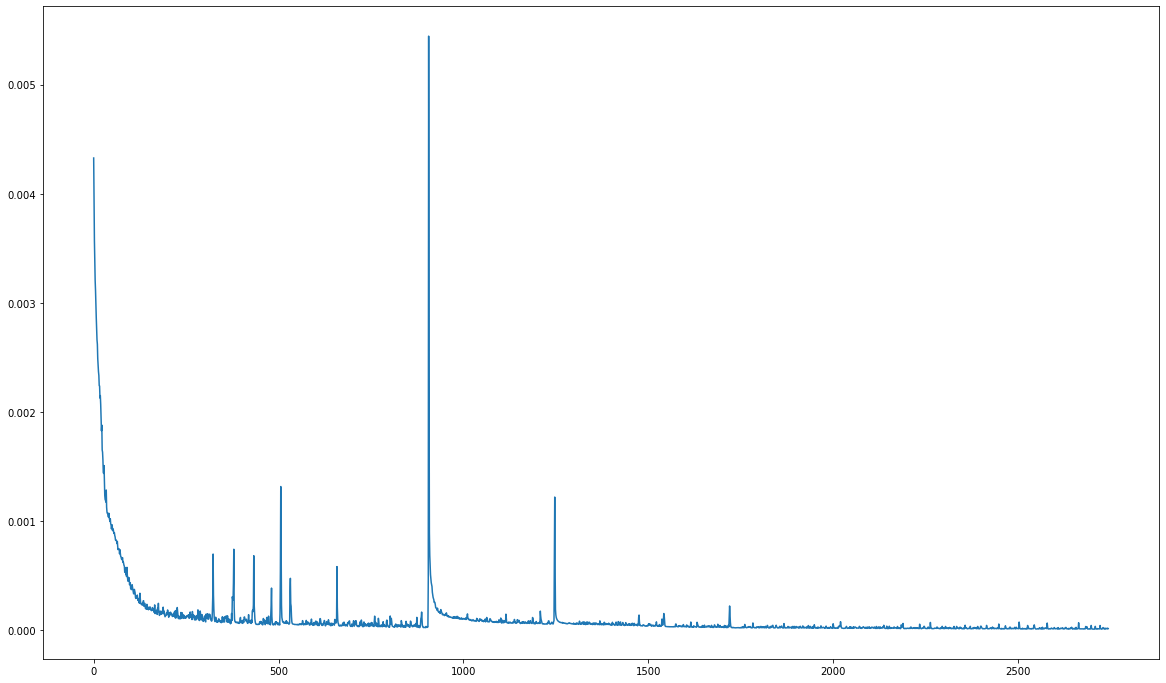

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize = (20, 12))
loss_list_p_1 = loss_list_p[5:]

plt.plot(list(range(len(loss_list_p_1))), loss_list_p_1)